In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from matplotlib import pyplot as plt
import seaborn as sns
import scipy as sp
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,Conv2D,MaxPooling2D,UpSampling2D, Dense
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras import regularizers
from tensorflow.keras import layers
from scipy.misc import derivative
import scipy.integrate as intg
import scipy as sp
from astroNN.nn.layers import MCDropout

### In this notebook, we use a compressed version of JLA compilation
#### First, we load the trained AutoEncoder

In [2]:
np.random.seed(0)

In [3]:
autoencoder = tf.keras.models.load_model('../models/autoencoderJLA.h5')
file2 = '../data/jla_binned_distances_31nodes_v1.txt'
syscov = np.loadtxt('../data/cov_jla_binned_distances_31nodes_v1.txt',skiprows=1).reshape((31,31))
data = pd.read_csv(file2, names=['z', '$D_L$'], sep = " ", skiprows=3)

shuffle = [x for x in range(len(data.values)) if x%2 == 0]
comp = [x for x in range(len(data.values)) if x%2 ==1]
shuffle.extend(comp)


z = data.values[:,0][shuffle]
dl = data.values[:,1:][shuffle]

scalerdl = StandardScaler()
scalerdl.fit(dl.reshape(-1, 1))
dll = scalerdl.transform(dl.reshape((-1,1)))

nsize = len(syscov)
np.shape(syscov)
errors = np.diag(syscov).reshape(nsize,1)
errors = errors[shuffle]
np.shape(errors)
len(data), len(errors)

(31, 31)

# FFNN

In [4]:
split = 0.8
ntrain = int(split * len(z))
indx = [ntrain]

# scalerz = StandardScaler()
# scalerz.fit(z.reshape(-1, 1))
# zz = scalerz.transform(z.reshape((-1,1)))

scalerdl = StandardScaler()
scalerdl.fit(dl.reshape(-1, 1))
dll = scalerdl.transform(dl.reshape((-1,1)))

# scalererr = StandardScaler()
# scalererr.fit(errors.reshape(-1, 1))
# errscl = scalererr.transform(errors.reshape((-1,1)))

z_train, z_test = np.split(z, indx)
y = np.concatenate((dll, errors), axis=1)
y_train, y_test = np.split(y, indx)



In [5]:
def model2_dropout(input_z):
    efirst = Dense(100, activation='relu', input_shape=(1,))(input_z)
    x = MCDropout(0.01)(efirst)
    x = Dense(100, activation='relu')(efirst)
    x = MCDropout(0.01)(x)
    x = Dense(100, activation='relu')(x)
    x = MCDropout(0.01)(x)
    x = Dense(50, activation='relu')(x)
    x = MCDropout(0.01)(x)
    elast = Dense(2, activation='linear')(x)
    return elast

input_z = Input(shape = (1,))
neural_model2 = Model(input_z, model2_dropout(input_z))
neural_model2.compile(loss='mean_squared_error', optimizer = "adam")
neural_model2.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
dense (Dense)                (None, 100)               200       
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
MCDropout_2 (MCDropout)      (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
MCDropout_3 (MCDropout)      (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 50)                5050  

In [6]:
model2_train = neural_model2.fit(z_train, y_train, batch_size=1,
                                    epochs=3000,verbose=1,
                                    validation_data=(z_test, y_test))
#                                     callbacks=callbacks)

Epoch 1/3000
24/24 [==============================] - 1s 11ms/step - loss: 0.4314 - val_loss: 0.4485
Epoch 2/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.4294 - val_loss: 0.3005
Epoch 3/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.2504 - val_loss: 0.0473
Epoch 4/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0787 - val_loss: 0.0125
Epoch 5/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0476 - val_loss: 0.0104
Epoch 6/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0195 - val_loss: 0.0063
Epoch 7/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0292 - val_loss: 0.0179
Epoch 8/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0151 - val_loss: 0.0036
Epoch 9/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0299 - val_loss: 0.0089
Epoch 10/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0250 - val_loss: 0.008

24/24 [==============================] - 0s 1ms/step - loss: 0.0037 - val_loss: 0.0051
Epoch 83/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0166 - val_loss: 0.0085
Epoch 84/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0061 - val_loss: 0.0045
Epoch 85/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0091 - val_loss: 0.0179
Epoch 86/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0157 - val_loss: 0.0031
Epoch 87/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0093 - val_loss: 0.0043
Epoch 88/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0066 - val_loss: 0.0029
Epoch 89/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0034 - val_loss: 0.0038
Epoch 90/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0045 - val_loss: 0.0031
Epoch 91/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0045 - val_loss: 0.0019
Epoc

24/24 [==============================] - 0s 1ms/step - loss: 0.0056 - val_loss: 0.0058
Epoch 163/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0175 - val_loss: 0.0038
Epoch 164/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0047 - val_loss: 0.0012
Epoch 165/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0076 - val_loss: 0.0084
Epoch 166/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0036 - val_loss: 0.0130
Epoch 167/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0063 - val_loss: 9.8761e-04
Epoch 168/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0013
Epoch 169/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0024 - val_loss: 0.0022
Epoch 170/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0021 - val_loss: 0.0024
Epoch 171/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0053 - val_loss

24/24 [==============================] - 0s 1ms/step - loss: 0.0037 - val_loss: 0.0045
Epoch 243/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0029 - val_loss: 0.0047
Epoch 244/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0046 - val_loss: 0.0020
Epoch 245/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0105 - val_loss: 5.2061e-04
Epoch 246/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0082 - val_loss: 0.0039
Epoch 247/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0086 - val_loss: 0.0055
Epoch 248/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0034 - val_loss: 0.0044
Epoch 249/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 250/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0027 - val_loss: 0.0051
Epoch 251/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0033 - val_loss

Epoch 322/3000
24/24 [==============================] - 0s 2ms/step - loss: 0.0018 - val_loss: 0.0011
Epoch 323/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0017 - val_loss: 0.0012
Epoch 324/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0091 - val_loss: 0.0068
Epoch 325/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0096 - val_loss: 0.0036
Epoch 326/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0046 - val_loss: 0.0024
Epoch 327/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0047 - val_loss: 0.0023
Epoch 328/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0028 - val_loss: 4.0084e-04
Epoch 329/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0040 - val_loss: 0.0026
Epoch 330/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0025 - val_loss: 0.0040
Epoch 331/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.

Epoch 402/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0051 - val_loss: 0.0062
Epoch 403/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0114 - val_loss: 0.0035
Epoch 404/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0037 - val_loss: 0.0164
Epoch 405/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0105 - val_loss: 0.0150
Epoch 406/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0095 - val_loss: 0.0017
Epoch 407/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0024 - val_loss: 0.0022
Epoch 408/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0034 - val_loss: 0.0013
Epoch 409/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0013 - val_loss: 6.0795e-04
Epoch 410/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 411/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.

24/24 [==============================] - 0s 1ms/step - loss: 0.0036 - val_loss: 0.0051
Epoch 482/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0035 - val_loss: 0.0039
Epoch 483/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0023 - val_loss: 0.0037
Epoch 484/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 0.0026
Epoch 485/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0088 - val_loss: 0.0033
Epoch 486/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0040 - val_loss: 0.0020
Epoch 487/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0022 - val_loss: 0.0022
Epoch 488/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0013 - val_loss: 0.0076
Epoch 489/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0066 - val_loss: 0.0025
Epoch 490/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0025 - val_loss: 5.

24/24 [==============================] - 0s 1ms/step - loss: 0.0028 - val_loss: 0.0023
Epoch 561/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0030 - val_loss: 0.0048
Epoch 562/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 0.0014
Epoch 563/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0017 - val_loss: 0.0016
Epoch 564/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0076 - val_loss: 0.0023
Epoch 565/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0013
Epoch 566/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0035 - val_loss: 5.9300e-04
Epoch 567/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0053
Epoch 568/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0030 - val_loss: 0.0039
Epoch 569/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0026 - val_loss

24/24 [==============================] - 0s 1ms/step - loss: 0.0017 - val_loss: 0.0025
Epoch 640/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0021 - val_loss: 0.0175
Epoch 641/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0045 - val_loss: 0.0012
Epoch 642/3000
24/24 [==============================] - 0s 1ms/step - loss: 9.0506e-04 - val_loss: 0.0012
Epoch 643/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0042 - val_loss: 4.7631e-04
Epoch 644/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0024 - val_loss: 0.0014
Epoch 645/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0021 - val_loss: 0.0013
Epoch 646/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 9.3027e-04
Epoch 647/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0063 - val_loss: 0.0012
Epoch 648/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0082 - 

24/24 [==============================] - 0s 1ms/step - loss: 0.0027 - val_loss: 0.0015
Epoch 719/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 5.7627e-04
Epoch 720/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0021 - val_loss: 0.0021
Epoch 721/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 8.5657e-04
Epoch 722/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 723/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0017
Epoch 724/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0052
Epoch 725/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0029 - val_loss: 0.0019
Epoch 726/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0038 - val_loss: 0.0017
Epoch 727/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0032 - val_

24/24 [==============================] - 0s 1ms/step - loss: 0.0030 - val_loss: 0.0142
Epoch 798/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0049 - val_loss: 0.0029
Epoch 799/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0108 - val_loss: 0.0039
Epoch 800/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0038 - val_loss: 0.0029
Epoch 801/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0025 - val_loss: 0.0022
Epoch 802/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0051 - val_loss: 8.6600e-04
Epoch 803/3000
24/24 [==============================] - 0s 1ms/step - loss: 8.0690e-04 - val_loss: 0.0010
Epoch 804/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0022 - val_loss: 0.0021
Epoch 805/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0040 - val_loss: 0.0034
Epoch 806/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0022 - val_

24/24 [==============================] - 0s 1ms/step - loss: 6.7754e-04 - val_loss: 0.0011
Epoch 877/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0025 - val_loss: 0.0086
Epoch 878/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0057
Epoch 879/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 880/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0047 - val_loss: 7.1459e-04
Epoch 881/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 5.3886e-04
Epoch 882/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0027 - val_loss: 0.0012
Epoch 883/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0114
Epoch 884/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0053 - val_loss: 0.0044
Epoch 885/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0043 - 

24/24 [==============================] - 0s 1ms/step - loss: 0.0027 - val_loss: 8.3141e-04
Epoch 956/3000
24/24 [==============================] - 0s 1ms/step - loss: 8.5230e-04 - val_loss: 0.0010
Epoch 957/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 0.0018
Epoch 958/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0015
Epoch 959/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0025 - val_loss: 0.0011
Epoch 960/3000
24/24 [==============================] - 0s 1ms/step - loss: 5.8833e-04 - val_loss: 0.0028
Epoch 961/3000
24/24 [==============================] - 0s 1ms/step - loss: 5.4202e-04 - val_loss: 7.9549e-04
Epoch 962/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 963/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0018 - val_loss: 0.0012
Epoch 964/3000
24/24 [==============================] - 0s 1ms/step - loss: 9

24/24 [==============================] - 0s 1ms/step - loss: 0.0048 - val_loss: 0.0016
Epoch 1035/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0045 - val_loss: 0.0010
Epoch 1036/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0031 - val_loss: 0.0024
Epoch 1037/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 9.0591e-04
Epoch 1038/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 4.3349e-04
Epoch 1039/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 0.0022
Epoch 1040/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0010 - val_loss: 0.0027
Epoch 1041/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 4.2673e-04
Epoch 1042/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0053 - val_loss: 0.0028
Epoch 1043/3000
24/24 [==============================] - 0s 1ms/step - loss: 

24/24 [==============================] - 0s 1ms/step - loss: 0.0052 - val_loss: 0.0028
Epoch 1113/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0145
Epoch 1114/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0057 - val_loss: 0.0098
Epoch 1115/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0025 - val_loss: 0.0013
Epoch 1116/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0038 - val_loss: 5.7994e-04
Epoch 1117/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0023 - val_loss: 0.0036
Epoch 1118/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0011
Epoch 1119/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 3.8296e-04
Epoch 1120/3000
24/24 [==============================] - 0s 1ms/step - loss: 9.1379e-04 - val_loss: 6.7454e-04
Epoch 1121/3000
24/24 [==============================] - 0s 1ms/step - lo

24/24 [==============================] - 0s 1ms/step - loss: 7.1082e-04 - val_loss: 4.3960e-04
Epoch 1191/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0021
Epoch 1192/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0032 - val_loss: 0.0028
Epoch 1193/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0030 - val_loss: 6.2581e-04
Epoch 1194/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0017 - val_loss: 2.2943e-04
Epoch 1195/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0022 - val_loss: 4.4457e-04
Epoch 1196/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0021 - val_loss: 0.0011
Epoch 1197/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0027 - val_loss: 0.0084
Epoch 1198/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0012
Epoch 1199/3000
24/24 [==============================] - 0s 1ms/step 

24/24 [==============================] - 0s 1ms/step - loss: 0.0057 - val_loss: 0.0026
Epoch 1269/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0029 - val_loss: 0.0016
Epoch 1270/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0036 - val_loss: 0.0012
Epoch 1271/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0015
Epoch 1272/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0055 - val_loss: 0.0021
Epoch 1273/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0031 - val_loss: 3.1924e-04
Epoch 1274/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0018 - val_loss: 0.0037
Epoch 1275/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0030 - val_loss: 0.0026
Epoch 1276/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0021
Epoch 1277/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0011 -

24/24 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 0.0059
Epoch 1347/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0022 - val_loss: 0.0013
Epoch 1348/3000
24/24 [==============================] - 0s 1ms/step - loss: 9.0024e-04 - val_loss: 0.0026
Epoch 1349/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0018
Epoch 1350/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0021 - val_loss: 4.1020e-04
Epoch 1351/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0015
Epoch 1352/3000
24/24 [==============================] - 0s 1ms/step - loss: 9.5714e-04 - val_loss: 0.0021
Epoch 1353/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0042 - val_loss: 0.0046
Epoch 1354/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0017 - val_loss: 0.0018
Epoch 1355/3000
24/24 [==============================] - 0s 1ms/step - loss: 

24/24 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 8.1110e-04
Epoch 1425/3000
24/24 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.0027
Epoch 1426/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0027 - val_loss: 0.0028
Epoch 1427/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0022 - val_loss: 0.0021
Epoch 1428/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0036 - val_loss: 0.0018
Epoch 1429/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0040 - val_loss: 0.0033
Epoch 1430/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0021 - val_loss: 0.0030
Epoch 1431/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0021 - val_loss: 0.0054
Epoch 1432/3000
24/24 [==============================] - 0s 1ms/step - loss: 6.5300e-04 - val_loss: 5.6479e-04
Epoch 1433/3000
24/24 [==============================] - 0s 1ms/step - loss: 

24/24 [==============================] - 0s 1ms/step - loss: 0.0029 - val_loss: 0.0034
Epoch 1503/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 9.3061e-04
Epoch 1504/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0029 - val_loss: 0.0043
Epoch 1505/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 1506/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0029 - val_loss: 0.0046
Epoch 1507/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 4.5230e-04
Epoch 1508/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0023 - val_loss: 9.5634e-04
Epoch 1509/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0018 - val_loss: 0.0018
Epoch 1510/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0016
Epoch 1511/3000
24/24 [==============================] - 0s 1ms/step - loss: 

Epoch 1580/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0032 - val_loss: 0.0024
Epoch 1581/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0038 - val_loss: 0.0122
Epoch 1582/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0065 - val_loss: 0.0041
Epoch 1583/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0024 - val_loss: 5.3985e-04
Epoch 1584/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0022 - val_loss: 4.9872e-04
Epoch 1585/3000
24/24 [==============================] - 0s 1ms/step - loss: 5.6903e-04 - val_loss: 0.0021
Epoch 1586/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0033 - val_loss: 2.5617e-04
Epoch 1587/3000
24/24 [==============================] - 0s 1ms/step - loss: 9.2228e-04 - val_loss: 0.0022
Epoch 1588/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0035 - val_loss: 0.0035
Epoch 1589/3000
24/24 [==============================

24/24 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 1659/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 9.0041e-04
Epoch 1660/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 7.9313e-04
Epoch 1661/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0011
Epoch 1662/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 2.6203e-04
Epoch 1663/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0017
Epoch 1664/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 7.4782e-04
Epoch 1665/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 4.1766e-04
Epoch 1666/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 6.5916e-04
Epoch 1667/3000
24/24 [==============================] - 0s 1ms/s

24/24 [==============================] - 0s 1ms/step - loss: 0.0048 - val_loss: 4.8339e-04
Epoch 1737/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0063 - val_loss: 0.0093
Epoch 1738/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0037 - val_loss: 0.0014
Epoch 1739/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0039 - val_loss: 0.0010
Epoch 1740/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0016
Epoch 1741/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0024 - val_loss: 0.0021
Epoch 1742/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 6.1211e-04
Epoch 1743/3000
24/24 [==============================] - 0s 1ms/step - loss: 7.3712e-04 - val_loss: 0.0036
Epoch 1744/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0031 - val_loss: 0.0015
Epoch 1745/3000
24/24 [==============================] - 0s 1ms/step - loss: 

24/24 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 9.5357e-04
Epoch 1815/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0045 - val_loss: 6.1949e-04
Epoch 1816/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0024 - val_loss: 3.9473e-04
Epoch 1817/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0014
Epoch 1818/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0024 - val_loss: 0.0015
Epoch 1819/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0048 - val_loss: 0.0010
Epoch 1820/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0028 - val_loss: 5.3794e-04
Epoch 1821/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0013 - val_loss: 6.4610e-04
Epoch 1822/3000
24/24 [==============================] - 0s 1ms/step - loss: 7.5125e-04 - val_loss: 0.0012
Epoch 1823/3000
24/24 [==============================] - 0s 1ms/s

24/24 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0019
Epoch 1893/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0033 - val_loss: 0.0047
Epoch 1894/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0017 - val_loss: 0.0025
Epoch 1895/3000
24/24 [==============================] - 0s 1ms/step - loss: 9.3240e-04 - val_loss: 0.0012
Epoch 1896/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0025 - val_loss: 4.4094e-04
Epoch 1897/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0018 - val_loss: 0.0029
Epoch 1898/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0027 - val_loss: 6.4501e-04
Epoch 1899/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 7.9778e-04
Epoch 1900/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0022 - val_loss: 0.0010
Epoch 1901/3000
24/24 [==============================] - 0s 1ms/step - lo

24/24 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 1971/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0023 - val_loss: 6.6253e-04
Epoch 1972/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0010
Epoch 1973/3000
24/24 [==============================] - 0s 1ms/step - loss: 7.2358e-04 - val_loss: 6.0064e-04
Epoch 1974/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0032 - val_loss: 0.0016
Epoch 1975/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0019
Epoch 1976/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0015
Epoch 1977/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0028 - val_loss: 0.0035
Epoch 1978/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0053 - val_loss: 0.0016
Epoch 1979/3000
24/24 [==============================] - 0s 1ms/step - loss: 

24/24 [==============================] - 0s 1ms/step - loss: 0.0013 - val_loss: 0.0019
Epoch 2049/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0026 - val_loss: 0.0036
Epoch 2050/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0040 - val_loss: 0.0017
Epoch 2051/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0059 - val_loss: 0.0018
Epoch 2052/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0028 - val_loss: 0.0029
Epoch 2053/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0011
Epoch 2054/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0027 - val_loss: 4.5959e-04
Epoch 2055/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0022 - val_loss: 0.0021
Epoch 2056/3000
24/24 [==============================] - 0s 1ms/step - loss: 9.9993e-04 - val_loss: 0.0016
Epoch 2057/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.00

24/24 [==============================] - 0s 1ms/step - loss: 0.0066 - val_loss: 7.5197e-04
Epoch 2127/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0034 - val_loss: 9.5897e-04
Epoch 2128/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0033 - val_loss: 0.0015
Epoch 2129/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0013 - val_loss: 0.0093
Epoch 2130/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0036 - val_loss: 0.0082
Epoch 2131/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0046 - val_loss: 0.0029
Epoch 2132/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 6.3291e-04
Epoch 2133/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0017 - val_loss: 0.0057
Epoch 2134/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0031 - val_loss: 8.4414e-04
Epoch 2135/3000
24/24 [==============================] - 0s 1ms/step - lo

24/24 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 6.6545e-04
Epoch 2205/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0025 - val_loss: 0.0085
Epoch 2206/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0036 - val_loss: 0.0032
Epoch 2207/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0017 - val_loss: 0.0038
Epoch 2208/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 6.4401e-04
Epoch 2209/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0024 - val_loss: 0.0028
Epoch 2210/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0026 - val_loss: 0.0027
Epoch 2211/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0085 - val_loss: 6.1709e-04
Epoch 2212/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0013 - val_loss: 5.7072e-04
Epoch 2213/3000
24/24 [==============================] - 0s 1ms/step - lo

24/24 [==============================] - 0s 1ms/step - loss: 0.0038 - val_loss: 0.0010
Epoch 2283/3000
24/24 [==============================] - 0s 1ms/step - loss: 9.9300e-04 - val_loss: 9.6721e-04
Epoch 2284/3000
24/24 [==============================] - 0s 1ms/step - loss: 9.2347e-04 - val_loss: 0.0029
Epoch 2285/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0037 - val_loss: 0.0014
Epoch 2286/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 7.7455e-04
Epoch 2287/3000
24/24 [==============================] - 0s 1ms/step - loss: 7.8340e-04 - val_loss: 0.0016
Epoch 2288/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 0.0022
Epoch 2289/3000
24/24 [==============================] - 0s 1ms/step - loss: 8.4364e-04 - val_loss: 5.7671e-04
Epoch 2290/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0023 - val_loss: 5.3441e-04
Epoch 2291/3000
24/24 [==============================] - 

24/24 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0017
Epoch 2361/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0023 - val_loss: 0.0020
Epoch 2362/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0030 - val_loss: 0.0018
Epoch 2363/3000
24/24 [==============================] - 0s 1ms/step - loss: 5.6376e-04 - val_loss: 9.8626e-04
Epoch 2364/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 2365/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0031
Epoch 2366/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0022 - val_loss: 0.0011
Epoch 2367/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0043 - val_loss: 0.0166
Epoch 2368/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0098 - val_loss: 0.0022
Epoch 2369/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.00

24/24 [==============================] - 0s 1ms/step - loss: 0.0021 - val_loss: 0.0015
Epoch 2439/3000
24/24 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 0.0032
Epoch 2440/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0033 - val_loss: 0.0011
Epoch 2441/3000
24/24 [==============================] - 0s 1ms/step - loss: 4.3513e-04 - val_loss: 5.5663e-04
Epoch 2442/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0015
Epoch 2443/3000
24/24 [==============================] - 0s 1ms/step - loss: 7.6511e-04 - val_loss: 0.0039
Epoch 2444/3000
24/24 [==============================] - 0s 1ms/step - loss: 4.5901e-04 - val_loss: 0.0014
Epoch 2445/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0013 - val_loss: 3.1928e-04
Epoch 2446/3000
24/24 [==============================] - 0s 1ms/step - loss: 5.2195e-04 - val_loss: 0.0019
Epoch 2447/3000
24/24 [==============================] - 0s 1ms/s

24/24 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 3.8068e-04
Epoch 2517/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0018 - val_loss: 7.9089e-04
Epoch 2518/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0017 - val_loss: 7.6165e-04
Epoch 2519/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0010 - val_loss: 0.0020
Epoch 2520/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0023 - val_loss: 0.0014
Epoch 2521/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0024
Epoch 2522/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0052 - val_loss: 7.3330e-04
Epoch 2523/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0040 - val_loss: 0.0047
Epoch 2524/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0050 - val_loss: 0.0041
Epoch 2525/3000
24/24 [==============================] - 0s 1ms/step - lo

24/24 [==============================] - 0s 1ms/step - loss: 0.0043 - val_loss: 0.0030
Epoch 2595/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0061 - val_loss: 0.0033
Epoch 2596/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0025 - val_loss: 2.0774e-04
Epoch 2597/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0014
Epoch 2598/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0025 - val_loss: 5.5274e-04
Epoch 2599/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0091 - val_loss: 0.0079
Epoch 2600/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0067 - val_loss: 0.0015
Epoch 2601/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0013 - val_loss: 0.0030
Epoch 2602/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0033
Epoch 2603/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.00

24/24 [==============================] - 0s 1ms/step - loss: 0.0010 - val_loss: 0.0029
Epoch 2673/3000
24/24 [==============================] - 0s 1ms/step - loss: 4.2012e-04 - val_loss: 0.0030
Epoch 2674/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0021 - val_loss: 0.0017
Epoch 2675/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0013 - val_loss: 0.0018
Epoch 2676/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0011
Epoch 2677/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0022 - val_loss: 0.0018
Epoch 2678/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0027
Epoch 2679/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0012
Epoch 2680/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0018 - val_loss: 0.0031
Epoch 2681/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0030 -

24/24 [==============================] - 0s 1ms/step - loss: 0.0067 - val_loss: 3.5924e-04
Epoch 2751/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0021 - val_loss: 0.0031
Epoch 2752/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0027 - val_loss: 0.0015
Epoch 2753/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0032
Epoch 2754/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0034 - val_loss: 4.9270e-04
Epoch 2755/3000
24/24 [==============================] - 0s 1ms/step - loss: 8.8133e-04 - val_loss: 0.0019
Epoch 2756/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0017 - val_loss: 6.9132e-04
Epoch 2757/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0028 - val_loss: 0.0024
Epoch 2758/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0024 - val_loss: 0.0041
Epoch 2759/3000
24/24 [==============================] - 0s 1ms/step - lo

24/24 [==============================] - 0s 1ms/step - loss: 5.4357e-04 - val_loss: 9.4661e-04
Epoch 2828/3000
24/24 [==============================] - 0s 1ms/step - loss: 4.4997e-04 - val_loss: 0.0010
Epoch 2829/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0015
Epoch 2830/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0010 - val_loss: 0.0076
Epoch 2831/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0064 - val_loss: 0.0031
Epoch 2832/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0029 - val_loss: 0.0012
Epoch 2833/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 7.2510e-04
Epoch 2834/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 7.3001e-04
Epoch 2835/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0068 - val_loss: 0.0044
Epoch 2836/3000
24/24 [==============================] - 0s 1ms/step 

Epoch 2905/3000
24/24 [==============================] - 0s 1ms/step - loss: 8.5926e-04 - val_loss: 9.2504e-04
Epoch 2906/3000
24/24 [==============================] - 0s 1ms/step - loss: 4.7222e-04 - val_loss: 3.5108e-04
Epoch 2907/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0018
Epoch 2908/3000
24/24 [==============================] - 0s 1ms/step - loss: 8.2432e-04 - val_loss: 4.0573e-04
Epoch 2909/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 3.6826e-04
Epoch 2910/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0024 - val_loss: 0.0036
Epoch 2911/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0010 - val_loss: 0.0021
Epoch 2912/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 6.8699e-04
Epoch 2913/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0018 - val_loss: 0.0036
Epoch 2914/3000
24/24 [==================

24/24 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0038
Epoch 2983/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0010 - val_loss: 2.8671e-04
Epoch 2984/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0032 - val_loss: 1.2841e-04
Epoch 2985/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0028 - val_loss: 0.0018
Epoch 2986/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0029 - val_loss: 0.0028
Epoch 2987/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0024
Epoch 2988/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 7.0441e-04
Epoch 2989/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0027 - val_loss: 5.6463e-04
Epoch 2990/3000
24/24 [==============================] - 0s 1ms/step - loss: 0.0017 - val_loss: 0.0010
Epoch 2991/3000
24/24 [==============================] - 0s 1ms/step - lo

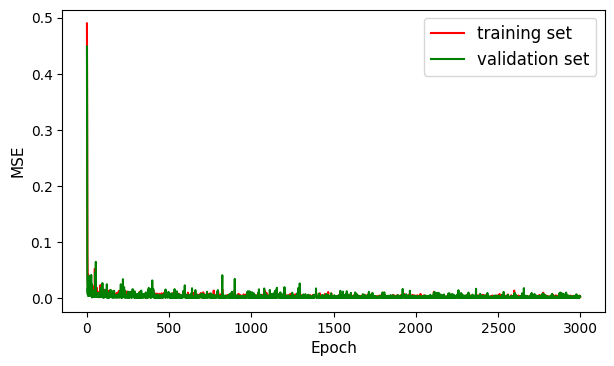

In [19]:
plt.figure(figsize=(7, 4), dpi=100)

plt.plot(model2_train.history['loss'], color='r', )
plt.plot(model2_train.history['val_loss'], color='g')

plt.ylabel('MSE', fontsize=11)
plt.xlabel('Epoch', fontsize=11)
plt.legend(['training set', 'validation set'], loc='upper right', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
# plt.title('FFNN+MC-DO', fontsize=8)

plt.savefig('loss_dropoutJLA2.png')

In [8]:
file3 = 'fake_binned_JLA2TEST1.dat'
data3 = pd.read_csv(file3, names=['z', '$D_L$'], sep = " ", skiprows=3)

x_test = data.values[:,0]
# dl = data.values[:,1:][shuffle]
np.shape(x_test)

(31,)

In [9]:
test_batch_size = 31
# x_test = np.random.uniform(np.min(z), np.max(z), test_batch_size)
# x_test = np.linspace(np.min(z), np.max(z), test_batch_size)

mc_dropout_num = 100# Run Dropout 100 times
predictions = np.zeros((mc_dropout_num, test_batch_size, 2))

for i in range(mc_dropout_num):
    predictions[i] = neural_model2.predict(x_test)
    

prediction_mc_dropout = np.mean(predictions, axis=0, dtype=np.float64)
std_mc_dropout = np.std(predictions, axis=0, dtype=np.float64)

# get mean results and its varience
predictions_dl = predictions[:,:,0]
predictions_err = predictions[:,:,1]

sigma = np.sqrt(std_mc_dropout[:, 0]**2 + std_mc_dropout[:, 1]**2+ prediction_mc_dropout[:,1]**2)

np.shape(predictions), np.shape(predictions_dl), np.shape(predictions_err), np.shape(prediction_mc_dropout)
# prediction_mc_dropout

((100, 31, 2), (100, 31), (100, 31), (31, 2))

In [10]:
Om = 0.27
# variance network
w0 = -1

# def RHSquared_a_lcdm(a):
# #         return Ezlcdm(a)**2
#     return Om*(1/a)**3 + 1 - Om

def RHSquared_a_owacdm(a, w0, wa):
#         return Ezlcdm(a)**2
    rhow = a**(-3*(1.0+w0+wa))*np.exp(-3*wa*(1-a))
    return (Om/a**3+(1.0-Om)*rhow)

def DistIntegrand_a(a, w0, wa):
#         if model == 'lcdm':
#             return 1./np.sqrt(RHSquared_a_lcdm(a))/a**2
#         elif model == 'owacdm':
        return 1./np.sqrt(RHSquared_a_owacdm(a, w0, wa))/a**2
    
def Da_z(z, w0, wa):
        # r=intg.quad(self.Hinv_z,0,z)
        # this version seems to be faster
        r = intg.quad(DistIntegrand_a, 1./(1+z), 1, args=(w0, wa))

        r = r[0]
      
        return r
    
def distance_modulus(z, w0=-1, wa=0.0):
        # I think this should also work with varyPrefactor as long as BAO is there too
        # assert(not self.varyPrefactor)

        # note that our Da_z is comoving, so we're only
        # multilpyting with a single (1+z) factor
#         return 5*np.log10(Da_z(z, model, w0, wa)*(1+z)) 
    return 5*np.log10(Da_z(z, w0, wa)*(1+z))+43



In [11]:
zmodel = np.linspace(0.01, 1.5, 100)
flcdm = []
fowacdm1 = []
# fowacdm2 = []
# fowacdm3 = []

# flcdm = []
for zzz in zmodel:
    flcdm.append(distance_modulus(zzz, w0=-1, wa=0))
#     fowacdm1.append(distance_modulus(zzz, w0=-1.3, wa=1.2))
    fowacdm1.append(distance_modulus(zzz, w0=-10, wa=-100))
#     fowacdm2.append(distance_modulus(zz, model='owacdm', w0=-1, wa=-0.5))
#     fowacdm3.append(distance_modulus(zz, model='owacdm', w0=-1, wa=0.0))
    
flcdm = np.array(flcdm)
fowacdm1 = np.array(fowacdm1)
# fowacdm2 = np.array(fowacdm2)
# fowacdm3 = np.array(fowacdm3)

(31, 1)


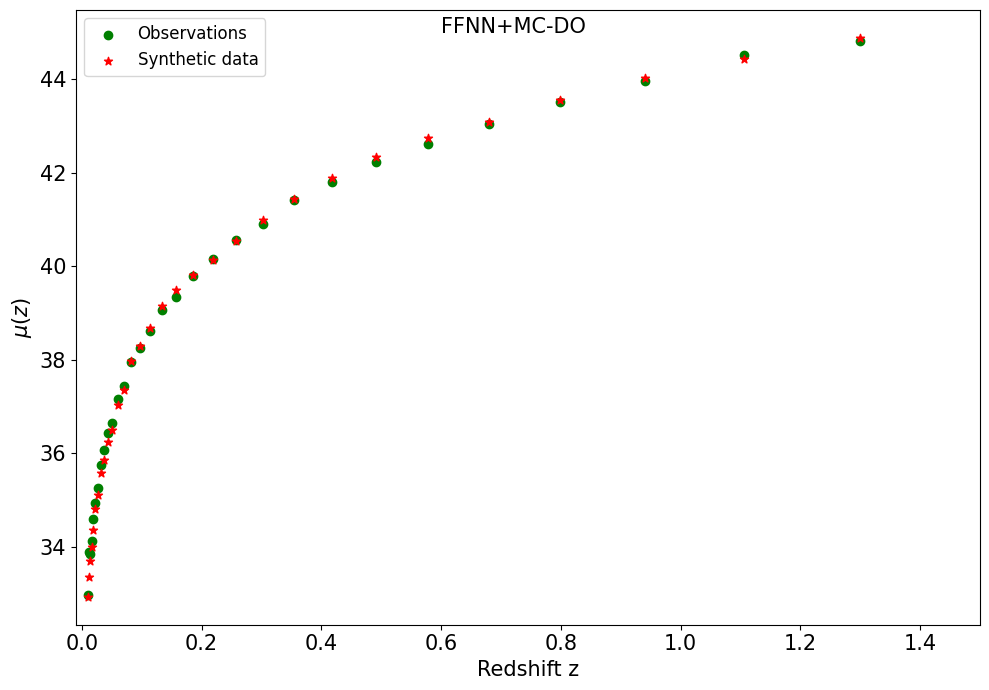

In [18]:
# Plotting
dlfake = scalerdl.inverse_transform(prediction_mc_dropout[:,0].reshape(-1,1))
plt.figure(figsize=(10, 7), dpi=100)
print(np.shape(dlfake))

# fakeerrors = np.sqrt(np.abs(np.diagonal(decoded_fake.reshape(31,31))))
# sigma = np.sqrt(std_mc_dropout.reshape(31,))

plt.scatter(z, dl, c='g', label='Observations')
# plt.errorbar(z, dl, errors, fmt='g.', markersize=10, label='Observations')
plt.scatter(x_test, dlfake, marker='*', c='r', label='Synthetic data')

# plt.errorbar(x_test, dlfake, yerr=sigma
#              , markersize=10, fmt='.', 
#              ecolor='blue', capthick=2, elinewidth=0.9, alpha=0.8, c='r',
#              label='Synthetic data')

# plt.scatter(scalerz.inverse_transform(zz), yy, color='k', label='Original cosmic chronometers')
# plt.plot(zmodel, flcdm, label='$\Lambda CDM$', c='b')
# plt.plot(zmodel, fowacdm1, label='CPL $w_0 = -1.3, w_a=1.2$', c='m')
# plt.plot(zmodel, fowacdm2, label='$\omega_0\omega_aCDM \;\; \omega_a=-0.5$', c='y')
# plt.plot(zmodel, Hlcdm(zmodel), label='$\Lambda CDM$ $H_0 = 73.24$', c='k')
# plt.plot(zmodel, Hlcdm(zmodel, H0=67.4), label='$\Lambda CDM$ $H_0 = 67.4$', c='b')
plt.xlim(-0.01, np.max(z)+0.2)
plt.xlabel("Redshift z", fontsize=15)
plt.ylabel("$\mu(z)$", fontsize=15)
# plt.xlim(0, np.max(z))
plt.xticks(fontsize=15)
plt.text(0.6, 45, 'FFNN+MC-DO', fontsize=15)
plt.yticks(fontsize=15)
plt.tight_layout()

plt.legend(loc='upper left', fontsize=12)
# plt.show()
plt.savefig('DL_dropoutb2.png')

In [20]:
index = np.argsort(x_test)
fake_data2 = np.stack((x_test[index], dlfake.reshape(31,)[index]), axis=1)


np.savetxt("fake_binned_JLADO.dat",  fake_data2, delimiter= " ", header="#fake data\n# z\n# mu", fmt='%1.9f')
np.savetxt("errors_JLA_DO.dat", predictions_err, delimiter= " ", header="#fake statistical errors", fmt='%1.9f')

In [17]:
# autoencoder.save('autoencoderJLA_DO.h5')
# decoder.save('decoderJLA_DO.h5')
neural_model2.save('FFNN_JLA_DO.h5')
# encoder.save('encoderJLA_DO.h5')

In [15]:
# plt.figure(figsize=(5, 3), dpi=100)
# plt.plot(model_train.history['loss'], color='r', )
# plt.plot(model_train.history['val_loss'], color='g')
# plt.ylabel('MSE', fontsize=9)
# plt.xlabel('Epoch', fontsize=9)
# plt.legend(['training set', 'validation set'], loc='upper right', fontsize=8)
# plt.xticks(fontsize=7)
# plt.yticks(fontsize=7)
# plt.title('FFNN', fontsize=8)
# plt.savefig("loss_hz.png", dpi=100)